# SOSE Data - cleaned version
Bottom Temperature and Salinity to compare with ECCOv4r3 and WOA products

In [1]:
from dask_gateway import Gateway
g = Gateway()
cluster = g.connect(g.list_clusters()[0].name)
client = cluster.get_client()

/srv/conda/envs/notebook/lib/python3.9/site-packages/dask_gateway/client.py:21: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import LoopRunner, format_bytes


In [2]:
client

Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.e7d7325618484fe6934a49d1a05ade9e/status,


In [3]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
%matplotlib inline
import cartopy.crs as ccrs #cartopy coord ref sys
import cartopy
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#import regionmask
import geopandas
import scipy
import xesmf as xe

In [4]:
fs = gcsfs.GCSFileSystem(requester_pays=True)

mapping = fs.get_mapper('gcs://pangeo-ecco-sose')

ds = xr.open_zarr(mapping, consolidated=True)
ds

<xarray.Dataset>
Dimensions:   (time: 438, Zl: 42, YC: 320, XC: 2160, Z: 42, XG: 2160, YG: 320,
               Zp1: 43, Zu: 42)
Coordinates: (12/26)
    Depth     (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    PHrefC    (Z) float32 dask.array<chunksize=(42,), meta=np.ndarray>
    PHrefF    (Zp1) float32 dask.array<chunksize=(43,), meta=np.ndarray>
  * XC        (XC) float32 0.08333 0.25 0.4167 0.5833 ... 359.6 359.8 359.9
  * XG        (XG) float32 5.551e-17 0.1667 0.3333 0.5 ... 359.5 359.7 359.8
  * YC        (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -25.04 -24.87 -24.71
    ...        ...
    iter      (time) int64 dask.array<chunksize=(438,), meta=np.ndarray>
    rA        (YC, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAs       (YG, XC) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAw       (YC, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
    rAz       (YG, XG) float32 dask.array<chunksize=(320, 2160), meta=np.ndarray>
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables: (12/56)
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVx_SLT  (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVx_TH   (time, Z, YC, XG) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVy_SLT  (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ADVy_TH   (time, Z, YG, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    ...        ...
    oceFreez  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    oceQsw    (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    oceTAUX   (time, YC, XG) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    oceTAUY   (time, YG, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surForcS  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>
    surForcT  (time, YC, XC) float32 dask.array<chunksize=(1, 320, 2160), meta=np.ndarray>

In [14]:
coords_before_drop = ds.coords.to_dataset().reset_coords().roll(XC=700, XG=700, roll_coords=True) #ds split into coords
dsr_before_drop = ds.reset_coords(drop=True).roll(XC=700, XG=700, roll_coords=True) #ds dropping coords so it just holds data variables

In [15]:
dsr = dsr_before_drop.drop(['XC', 'YC', 'XG', 'YG'])
coords = coords_before_drop.drop(['XC', 'YC', 'XG', 'YG'])

In [16]:
#WG boundaries (65˚W, 30˚E; 80˚S, 62˚S)
#WG model's boundaries (-77.87497˚S, -62.041634˚S; 295.08334W, 30.083334E)
lower_lat = 0
upper_lat = 95
left_lon =  310
right_lon = 880

In [17]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

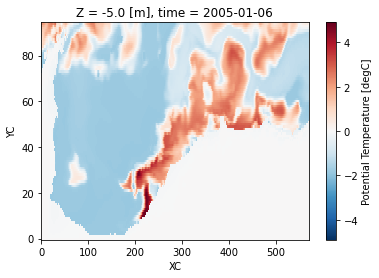

In [18]:
dsr.THETA[0,0].isel(**lat_range, **lon_range).plot()#.drop(['XC', 'YC']).plot()

In [19]:
temp_wg = dsr.THETA.isel(**lat_range, **lon_range)

In [20]:
temp_wg_mean = temp_wg.mean(dim='time')
temp_wg_mean

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Dimensions without coordinates: YC, XC

In [21]:
temp_wg_mean.XC

<xarray.DataArray 'XC' (XC: 570)>
array([  0,   1,   2, ..., 567, 568, 569])
Dimensions without coordinates: XC

In [22]:
#this gives us the depth of the bottom cell
depth_max = dsr.Z.where(temp_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [23]:
depth_max

<xarray.DataArray 'Z' (YC: 95, XC: 570)>
dask.array<_nanmax_skip-aggregate, shape=(95, 570), dtype=float32, chunksize=(95, 570), chunktype=numpy.ndarray>
Dimensions without coordinates: YC, XC

In [25]:
bottom_temp = temp_wg_mean.sel(Z=depth_max.fillna(0.)).load()

In [55]:
surface_mask = (coords.hFacC[0].isel(**lat_range, **lon_range)>0).load()

In [67]:
surface_mask.to_netcdf('surface_mask.nc')

In [26]:
lon = coords_before_drop.XC.isel(**lon_range)
lat = coords_before_drop.YC.isel(**lat_range)

In [27]:
lon

<xarray.DataArray 'XC' (XC: 570)>
array([295.08334 , 295.25    , 295.4167  , ...,  29.583334,  29.75    ,
        29.916668], dtype=float32)
Coordinates:
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
Attributes:
    axis:           X
    coordinate:     YC XC
    long_name:      longitude
    standard_name:  longitude
    units:          degrees_east

In [28]:
bottom_temp['lat'] = lat
bottom_temp['lon'] = lon

In [29]:
bottom_temp

<xarray.DataArray 'THETA' (YC: 95, XC: 570)>
array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.59500206,  0.59372324,  0.5860209 , ..., -0.61448747,
        -0.61401767, -0.6136384 ],
       [ 0.7132437 ,  0.7120261 ,  0.7027545 , ..., -0.5988263 ,
        -0.59873897, -0.5980881 ],
       [ 0.8445248 ,  0.8352686 ,  0.8186579 , ..., -0.57839876,
        -0.5790265 , -0.5787111 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
  * YC       (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
    lat      (YC) float32 -77.87 -77.71 -77.54 -77.37 ... -62.54 -62.37 -62.21
  * XC       (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92
    lon      (XC) float32 295.1 295.2 295.4 295.6 ... 29.42 29.58 29.75 29.92

In [35]:
bottom_temp.to_netcdf('bottom_temp.nc')

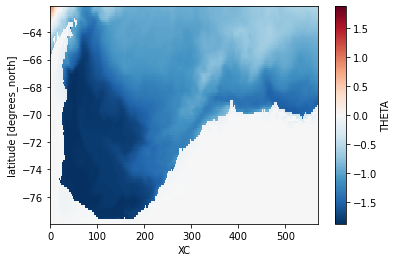

In [32]:
bottom_temp.drop('XC').plot()

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


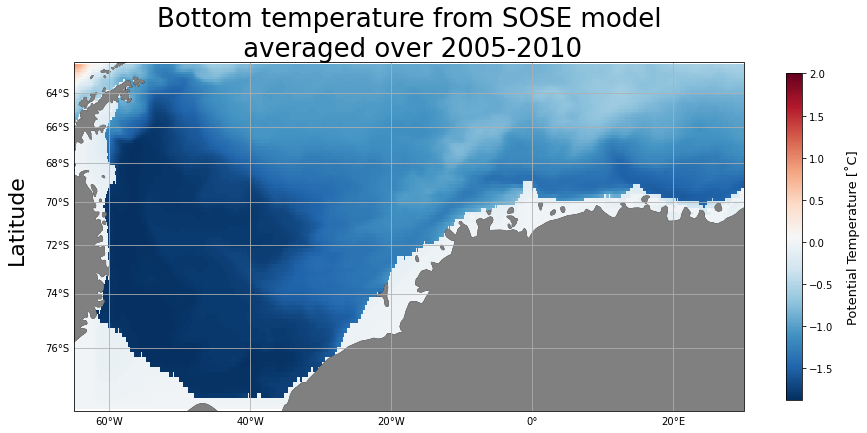

In [36]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')

ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_temp, transform=ccrs.PlateCarree(), cmap='RdBu_r', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Potential Temperature [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
        rotation='vertical', rotation_mode='anchor',
        transform=ax.transAxes, fontsize=22)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom temperature from SOSE model\n averaged over 2005-2010', fontsize=26)
plt.savefig('bot-temp-sose.pdf');

## <span style='color:Red'> Bottom Temperature Standard Deviation (start)

In [37]:
std_temp = temp_wg.std('time').load()

In [38]:
std_temp

<xarray.DataArray 'THETA' (Z: 42, YC: 95, XC: 570)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [1.9401149 , 1.9315456 , 1.925773  , ..., 1.6168126 ,
         1.6183969 , 1.6180696 ],
        [1.9405234 , 1.9307938 , 1.9231234 , ..., 1.6200324 ,
         1.6224138 , 1.6237788 ],
        [1.9323751 , 1.9223851 , 1.9137712 , ..., 1.6269828 ,
         1.6288462 , 1.6300234 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Dimensions without coordinates: YC, XC

In [39]:
#this gives us the depth of the bottom cell
depth_max_std_temp = dsr.Z.where(std_temp.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [40]:
depth_max_std_temp

<xarray.DataArray 'Z' (YC: 95, XC: 570)>
array([[-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       ...,
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.],
       [-5., -5., -5., ..., -5., -5., -5.]], dtype=float32)
Dimensions without coordinates: YC, XC

In [41]:
bottom_std_temp = std_temp.sel(Z=depth_max_std_temp.fillna(0.)).load()

In [42]:
bottom_std_temp

<xarray.DataArray 'THETA' (YC: 95, XC: 570)>
array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       ...,
       [1.9401149, 1.9315456, 1.925773 , ..., 1.6168126, 1.6183969,
        1.6180696],
       [1.9405234, 1.9307938, 1.9231234, ..., 1.6200324, 1.6224138,
        1.6237788],
       [1.9323751, 1.9223851, 1.9137712, ..., 1.6269828, 1.6288462,
        1.6300234]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


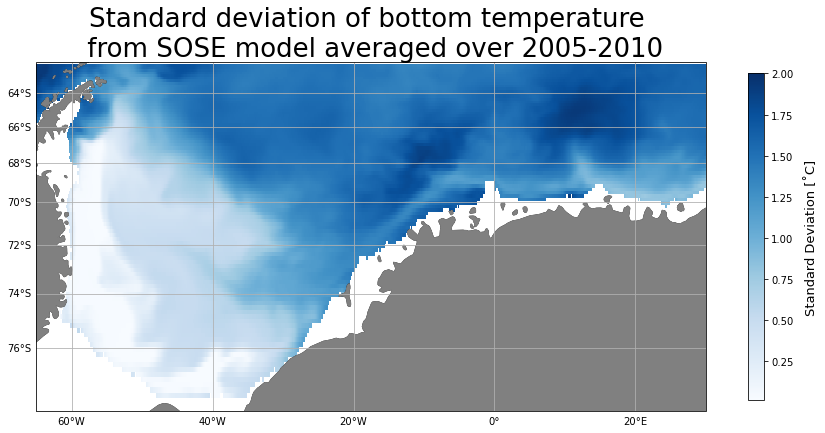

In [56]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.coastlines(resolution='50m')
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor='0.5'))
im = ax.pcolormesh(lon, lat, bottom_std_temp.where(surface_mask), transform=ccrs.PlateCarree(), cmap='Blues', vmax=2)
cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label("Standard Deviation [˚C]", labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard deviation of bottom temperature \n from SOSE model averaged over 2005-2010', fontsize=26)
plt.savefig('std-bot-temp-sose.pdf');

<span style='color:Green'> **The darker the blue, the more the datapoint is away from mean temperature**

## <span style='color:Red'> Bottom Temperature Standard Deviation (end)

## <span style='color:Red'> Bottom Temperature Z-score (start)
    
* Don't so Z score in this case

## <span style='color:Red'> Bottom Temperature Z-score (end)

## BOTTOM SALT

In [47]:
slt_wg = dsr.SALT.isel(**lat_range, **lon_range)

In [48]:
slt_wg_mean = slt_wg.mean(dim='time')
slt_wg_mean

<xarray.DataArray 'SALT' (Z: 42, YC: 95, XC: 570)>
dask.array<mean_agg-aggregate, shape=(42, 95, 570), dtype=float32, chunksize=(42, 95, 570), chunktype=numpy.ndarray>
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Dimensions without coordinates: YC, XC

In [49]:
#this gives us the depth of the bottom cell
depth_max_slt = dsr.Z.where(slt_wg_mean.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [50]:
bottom_slt = slt_wg_mean.sel(Z=depth_max_slt.fillna(0.)).load()

In [51]:
bottom_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,
         0.      ],
       ...,
       [33.708538, 33.709415, 33.709522, ..., 33.853043, 33.854958,
        33.856647],
       [33.72277 , 33.723537, 33.72321 , ..., 33.855934, 33.8571  ,
        33.858185],
       [33.741817, 33.74131 , 33.739555, ..., 33.85897 , 33.859295,
        33.85984 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

In [52]:
bottom_slt['lat'] = coords_before_drop.YC.isel(**lat_range)
bottom_slt['lon'] = coords_before_drop.XC.isel(**lon_range)

In [68]:
bottom_slt.to_netcdf('bottom_slt.nc')

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


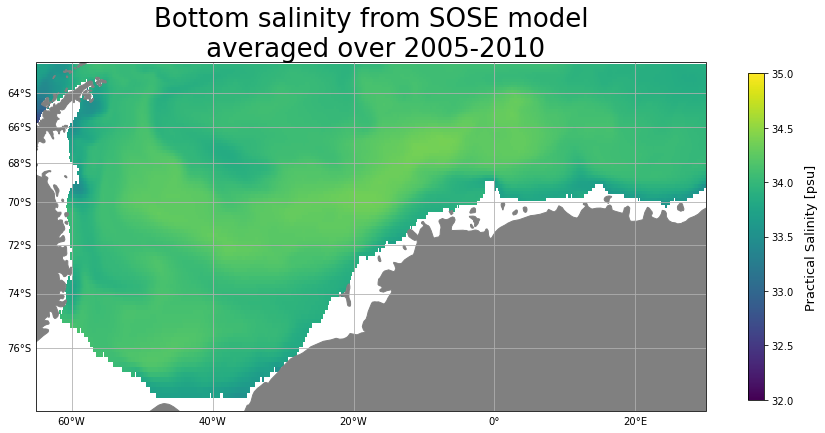

In [59]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_slt.where(surface_mask), transform=ccrs.PlateCarree(), vmin=32, vmax=35, cmap='viridis')

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Practical Salinity [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Bottom salinity from SOSE model\n averaged over 2005-2010', fontsize=26 )
plt.savefig('bot-salt-sose.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (start)

In [60]:
std_slt = slt_wg.std('time').load()

In [61]:
std_slt

<xarray.DataArray 'SALT' (Z: 42, YC: 95, XC: 570)>
array([[[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.16349815, 0.16455886, 0.16600156, ..., 0.26004484,
         0.2624796 , 0.26455685],
        [0.15929526, 0.15990709, 0.16109149, ..., 0.24494264,
         0.24762833, 0.2505836 ],
        [0.15186515, 0.15275356, 0.15425907, ..., 0.23001364,
         0.23254564, 0.2355742 ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
...
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]],

       [[0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , ..., 0.        ,
         0.        , 0.        ]]], dtype=float32)
Coordinates:
  * Z        (Z) float32 -5.0 -15.5 -27.0 ... -5.075e+03 -5.325e+03 -5.575e+03
Dimensions without coordinates: YC, XC

In [62]:
#this gives us the depth of the bottom cell
depth_max_std_slt = dsr.Z.where(std_slt.notnull()).max(dim='Z') #use Z instead of Depth bc Depth doesn't have dim Z

In [63]:
bottom_std_slt = std_slt.sel(Z=depth_max_std_slt.fillna(0.)).load()

In [64]:
bottom_std_slt

<xarray.DataArray 'SALT' (YC: 95, XC: 570)>
array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.16349815, 0.16455886, 0.16600156, ..., 0.26004484, 0.2624796 ,
        0.26455685],
       [0.15929526, 0.15990709, 0.16109149, ..., 0.24494264, 0.24762833,
        0.2505836 ],
       [0.15186515, 0.15275356, 0.15425907, ..., 0.23001364, 0.23254564,
        0.2355742 ]], dtype=float32)
Coordinates:
    Z        (YC, XC) float64 -5.0 -5.0 -5.0 -5.0 -5.0 ... -5.0 -5.0 -5.0 -5.0
Dimensions without coordinates: YC, XC

/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/srv/conda/envs/notebook/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


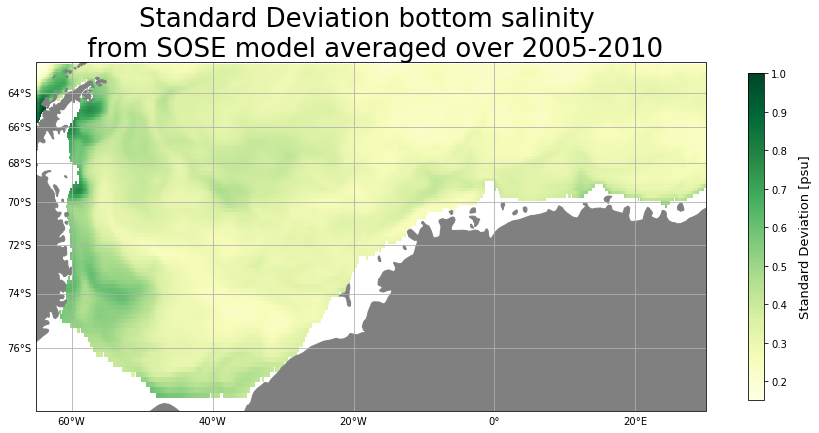

In [66]:
proj = ccrs.Mercator() #with Mercator you can put lat lon values.
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(projection=proj))

ax.set_extent([-65, 30, -78, -62], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                            edgecolor='face',
                                            facecolor='0.5'))

im = ax.pcolormesh(lon, lat, bottom_std_slt.where(surface_mask), transform=ccrs.PlateCarree(), cmap='YlGn', vmax=1)

cb = fig.colorbar(im, ax=ax, shrink=0.4)
cb.set_label('Standard Deviation [psu]', labelpad=12, fontsize=13)

g1 = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
g1.xlabels_top = False
g1.ylabels_right = False

#ax.text(-0.07, 0.55, 'Latitude', va='bottom', ha='center',
#        rotation='vertical', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)
#ax.text(0.5, -0.13, 'Longitude', va='bottom', ha='center',
#        rotation='horizontal', rotation_mode='anchor',
#        transform=ax.transAxes, fontsize=12)

plt.title('Standard Deviation bottom salinity \n from SOSE model averaged over 2005-2010', fontsize=26 )
plt.savefig('std-bot-salt-sose.pdf');

## <span style='color:Red'> Bottom Salinity Standard Deviation (end)

## <span style='color:Red'> Bottom Salinity Z-score (start)
    
* Don't do Z score in the case

## <span style='color:Red'> Bottom Salinity Z-score (end)